In [148]:
# Load required libraries
import requests
import numpy as np
import pandas as pd
import joblib
import time
import random
from IPython.core.display import clear_output
from bs4 import BeautifulSoup

In [149]:
# Load required libraries
import nltk
from bs4 import BeautifulSoup
import re
import lxml
import pandas as pd
import numpy as np
import joblib

from PIL import Image as IMG
import collections
from collections import defaultdict
import operator
import os

In [217]:
from collections import defaultdict
from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import feature
from PIL import Image as IMG
import numpy as np
import pandas as pd 
import operator
import cv2
import os 

from skimage.io import imread, imshow

from IPython.core.display import HTML 
from IPython.display import Image
%matplotlib inline

In [151]:
images_path = '/home/mosto/Documents/insight/kickstarter-project/images/'
imgs = os.listdir(images_path)

First change image file names to correct index for datafram

In [40]:
# Fix file names
# Only Use this if image name =! index name to replace name with index. In my case I needed to
# remove the first part of the file name
for file_name in os.listdir(images_path):
    os.rename(images_path+file_name, images_path+file_name.split('_',1)[1])


    

In [43]:
imgs = os.listdir(images_path)

In [44]:
features = pd.DataFrame()
features['image'] = imgs

Start Image Analysis

In [152]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [153]:
def perform_color_analysis(img, flag):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [47]:
features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))

In [50]:
topdull = features.sort_values('dullness', ascending = False)
topdull.head(5)

,image,dullness
3579,72006,100.0
2217,192925,100.0
4728,42684,100.0
620,33772,100.0
4723,159693,100.0


In [54]:
image_path

NameError: name 'image_path' is not defined

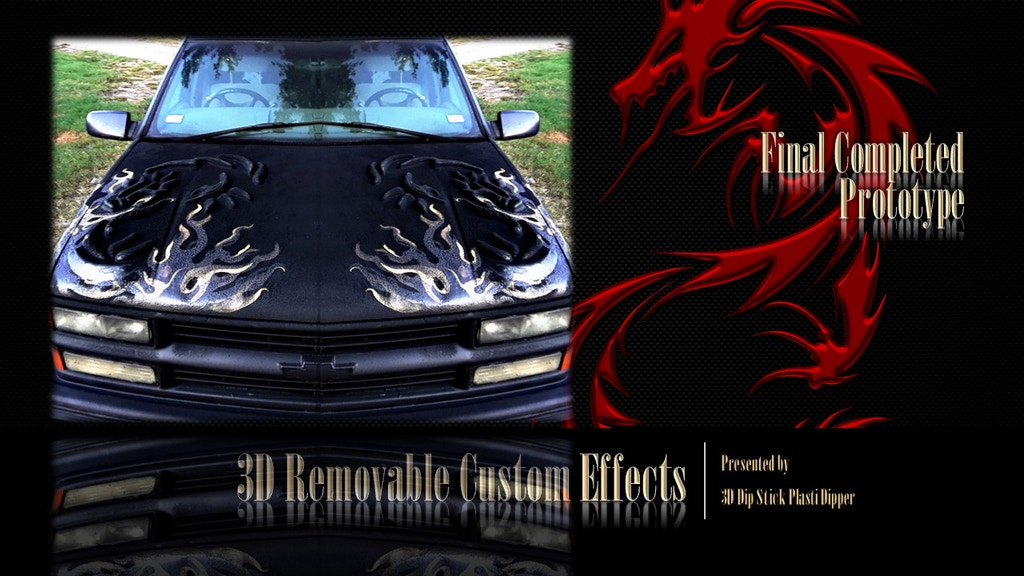

1

In [161]:
display(IMG.open(images_path+'159380'), IMG.ANTIALIAS)

In [83]:
start_time = time.time()
passed_time = time.time()-start_time
print(str(passed_time)+' seconds / '+str(passed_time/(3600))+' hours')

3.8623809814453125e-05 seconds / 1.0728836059570312e-08 hours


In [63]:
start_time = time.time()
features['brightness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
passed_time = time.time()-start_time
print(str(passed_time)+' seconds')

1607.8809988498688 seconds


In [66]:
topbright = features.sort_values('brightness', ascending = False)
topbright.head(5)

,image,dullness,brightness
4806,86037,0.0,100.0
3516,86630,0.0,100.0
1091,131602,0.0,100.0
2035,91714,0.0,100.0
3279,40371,0.0,100.0


In [154]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [67]:
start_time = time.time()
features['average_pixel_width'] = features['image'].apply(average_pixel_width)
passed_time = time.time()-start_time
print(str(passed_time)+' seconds')

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1172.7618379592896 seconds


In [71]:
tempdf = features.sort_values('average_pixel_width').head(-5)
tempdf 

,image,dullness,brightness,average_pixel_width
198,79064,0.000,0.000,0.000000
3072,184869,86.035,0.000,0.000000
4657,81228,100.000,0.000,0.000000
3464,186300,98.790,0.000,0.000000
2604,29320,100.000,0.000,0.000000
...,...,...,...,...
3275,95623,0.000,0.000,9.165955
3066,109462,33.570,0.000,9.238180
3285,88930,14.295,65.740,9.277513
1902,93655,17.240,9.680,9.405962


In [90]:
tempdf = features['average_pixel_width']
tempdf[0]

0.7685343424479167

In [155]:
def get_dominant_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    arr = np.float32(img)
    try:
        pixels = arr.reshape((-1, 3))

        n_colors = 5
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        flags = cv2.KMEANS_RANDOM_CENTERS
        _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

        palette = np.uint8(centroids)
        quantized = palette[labels.flatten()]
        quantized = quantized.reshape(img.shape)
        dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
        
    except:
        print('next entry')
        
    return dominant_color

In [135]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                4957 non-null   object 
 1   dullness             4917 non-null   float64
 2   brightness           4917 non-null   float64
 3   average_pixel_width  4957 non-null   float64
dtypes: float64(3), object(1)
memory usage: 155.0+ KB


In [163]:
features.iloc[545]

image                  159380
dullness               98.405
brightness                  0
average_pixel_width    3.3354
Name: 545, dtype: object

In [138]:
features.shape[0]

4957

In [164]:
features3 = features2.drop([features.index[545]]) 

In [165]:
features3.shape

(4955, 4)

In [166]:
features3.head()

,image,dullness,brightness,average_pixel_width
0,94899,0.00,60.88,0.768534
1,162481,0.00,0.00,5.192227
2,201573,0.00,0.00,5.105082
3,159292,0.00,0.00,2.721759
4,68557,7.93,0.00,0.367261


Rows deleted: (1){518:161065}(2){545:159380}(3)

features3 = features2.drop([features.index[545]]) 

In [113]:
#features[features.image != '161065']

,image,dullness,brightness,average_pixel_width
0,94899,0.000,60.880,0.768534
1,162481,0.000,0.000,5.192227
2,201573,0.000,0.000,5.105082
3,159292,0.000,0.000,2.721759
4,68557,7.930,0.000,0.367261
...,...,...,...,...
4952,148087,42.900,3.910,2.254564
4953,93010,99.580,0.420,2.523804
4954,65148,79.370,0.010,0.685440
4955,87351,94.125,0.805,0.873720


In [156]:
start_time = time.time()
features2['dominant_color'] = features2['image'].apply(get_dominant_color)
passed_time = time.time()-start_time
print(str(passed_time)+' seconds / '+str(passed_time/(3600))+' hours')

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


next entry


UnboundLocalError: local variable 'dominant_color' referenced before assignment

In [193]:
images=[]
dominant_color=[]

In [194]:
dominant_color=values

In [195]:
d = {'image':images, 'dominant_color':dominant_color}

In [198]:
d_dominant_color = dict(zip(images, dominant_color))
d_dominant_color

{}

In [162]:
for row in range(543,560,1):
    features2.iloc[row]['dominant_color'] = get_dominant_color(features2.iloc[row]['image'])
    print(str(row))

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()
/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


543
544
next entry


UnboundLocalError: local variable 'dominant_color' referenced before assignment

In [170]:
features3.iloc[0]['image']

'94899'

In [174]:
for row in range(features3.shape[0]):
    image = features3.iloc[row]['image']
    images.append(image)
    dominant_color = get_dominant_color(features3.iloc[row]['image'])
    dominant_color.append(dominant_color)
    features3.iloc[row]['dominant_color'] = dominant_color
    print(str(row))

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()
/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

UnboundLocalError: local variable 'dominant_color' referenced before assignment

In [185]:
images

['94899',
 '162481',
 '201573',
 '159292',
 '68557',
 '177507',
 '177909',
 '75373',
 '41601',
 '102666',
 '191957',
 '184063',
 '90070',
 '93186',
 '16934',
 '71110',
 '182992',
 '133055',
 '183636',
 '43967',
 '75751',
 '64123',
 '6888',
 '129604',
 '197645',
 '73899',
 '120598',
 '134506',
 '196080',
 '146714',
 '2860',
 '129555',
 '86451',
 '101162',
 '41131',
 '46462',
 '160302',
 '29726',
 '49609',
 '90626',
 '184148',
 '32817',
 '17159',
 '134377',
 '16518',
 '41692',
 '197721',
 '20230',
 '97018',
 '63397',
 '58237',
 '40411',
 '118119',
 '40875',
 '181153',
 '203819',
 '149148',
 '153149',
 '33436',
 '2206',
 '129327',
 '64770',
 '116474',
 '202876',
 '187926',
 '150815',
 '192911',
 '128178',
 '23617',
 '178453',
 '102982',
 '69451',
 '66303',
 '27617',
 '149700',
 '8401',
 '184435',
 '36465',
 '69609',
 '31073',
 '191193',
 '29772',
 '122725',
 '91403',
 '12563',
 '67765',
 '51328',
 '13384',
 '187376',
 '25232',
 '143000',
 '197512',
 '14009',
 '118286',
 '32271',
 '140804'

In [197]:
d_dominant_color[images[0]]

IndexError: list index out of range

In [94]:
start_time = time.time()
features['dominant_color'] = features['image'].apply(get_dominant_color)
passed_time = time.time()-start_time
print(str(passed_time)+' seconds / '+str(passed_time/(3600))+' hours')

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


next entry


UnboundLocalError: local variable 'dominant_color' referenced before assignment

In [328]:
images_list=[]
ave_color_list=[]

In [329]:
d_ave_color = dict(zip(images_list, ave_color_list))
d_ave_color

{}

In [330]:
def get_average_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    return average_color

In [192]:
get_average_color('94899')

[240.86637708875867, 212.18375311957465, 138.97493998209634]

In [190]:
start_time = time.time()
features['average_color'] = features['image'].apply(get_average_color)
passed_time = time.time()-start_time
print(str(passed_time)+' seconds')

AttributeError: 'NoneType' object has no attribute 'shape'

In [233]:
d_frame = features
image = d_frame.iloc[542]['image']
image

'28263'

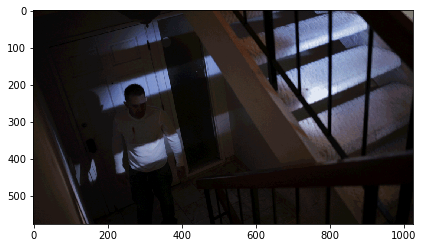

In [265]:
# Look at image 
d_frame = features
row = 759
image = d_frame.iloc[row]['image']
path = '/home/mosto/Documents/insight/kickstarter-project/images/'
im = imread(path+str(image))
imshow(im)

In [229]:
d_frame.loc[d_frame.index==542]

,image,dullness,brightness,average_pixel_width
542,28263,0.0,20.595,2.340918


Rows deleted: (1){518:161065}(2){545:159380}(3){545:159380}(4){544:193983}

features2 = features.drop([features.index[518]]) 
features3 = features2.drop([features.index[545]])
features4 = features3.drop([features.index[544]])

In [207]:
features2 = features.drop([features.index[518]]) 

In [210]:
features3 = features2.drop([features.index[545]])

In [222]:
features4 = features3.drop([features.index[544]])

In [266]:
d_frame = features
row = 759
image = d_frame.iloc[row]['image']
get_average_color(image)

AttributeError: 'NoneType' object has no attribute 'shape'

In [254]:
d_frame.shape[0]

4957

In [ ]:
# Need to remove pictures that don't fit the model. It will stop on the last working one, then fail
#(record this next number below) then start range after skipped value)
# 518,546,759,784,948,1459,1525,1602,1677,1758,1965,2046,2127,2192,2365,2420,2476,2637,2954,3435,3620,3662
# 3873,3893,3913,4176,4422,4605

In [314]:
to_drop=[518,546,759,784,948,1459,1525,1602,1677,1758,1965,2046,2127,2192,2365,2420,2476,2637,2954,3435,3620,3662,3873,3893,3913,4176,4422,4605]
to_drop=list(map(int, to_drop))
to_drop

[518,
 546,
 759,
 784,
 948,
 1459,
 1525,
 1602,
 1677,
 1758,
 1965,
 2046,
 2127,
 2192,
 2365,
 2420,
 2476,
 2637,
 2954,
 3435,
 3620,
 3662,
 3873,
 3893,
 3913,
 4176,
 4422,
 4605]

In [313]:
type(features.index[0])

int

In [315]:
features_dropped = features.drop(index=to_drop) 

In [318]:
features.shape

(4957, 4)

In [317]:
features_dropped.shape

(4929, 4)

In [331]:
d_frame = features_dropped
start_time = time.time()
for row in range(0,4929,1):
    image = d_frame.iloc[row]['image']
    images_list.append(image)
    ave_color = get_average_color(d_frame.iloc[row]['image'])
    ave_color_list.append(ave_color)
    d_frame.iloc[row]['average_color'] = ave_color
    print(str(row))
passed_time = time.time()-start_time    
print(str(passed_time)+' seconds')

/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mosto/miniconda3/envs/kickstarter/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


In [332]:
len(ave_color_list)

4929

In [333]:
d_frame.shape

(4929, 4)

In [342]:
d_frame['average_color']=ave_color_list
features=d_frame

In [343]:
features.head()

,image,dullness,brightness,average_pixel_width,average_color
0,94899,0.00,60.88,0.768534,"[240.86637708875867, 212.18375311957465, 138.9..."
1,162481,0.00,0.00,5.192227,"[118.4811774359809, 128.5906219482422, 125.515..."
2,201573,0.00,0.00,5.105082,"[102.67853122287326, 92.08284335666232, 180.79..."
3,159292,0.00,0.00,2.721759,"[75.76579604633861, 110.38401914242864, 143.18..."
4,68557,7.93,0.00,0.367261,"[89.36553211464201, 97.02202309254733, 109.570..."


In [344]:
features['average_red'] = features['average_color'].apply(lambda x: x[0]) / 255
features['average_green'] = features['average_color'].apply(lambda x: x[1]) / 255
features['average_blue'] = features['average_color'].apply(lambda x: x[2]) / 255

In [345]:
features[['average_red', 'average_green', 'average_blue']].head(5)

,average_red,average_green,average_blue
0,0.944574,0.832093,0.545000
1,0.464632,0.504277,0.492219
2,0.402661,0.361109,0.708983
3,0.297121,0.432879,0.561527
4,0.350453,0.380479,0.429687


In [347]:
features.head()

,image,dullness,brightness,average_pixel_width,average_color,average_red,average_green,average_blue
0,94899,0.00,60.88,0.768534,"[240.86637708875867, 212.18375311957465, 138.9...",0.944574,0.832093,0.545000
1,162481,0.00,0.00,5.192227,"[118.4811774359809, 128.5906219482422, 125.515...",0.464632,0.504277,0.492219
2,201573,0.00,0.00,5.105082,"[102.67853122287326, 92.08284335666232, 180.79...",0.402661,0.361109,0.708983
3,159292,0.00,0.00,2.721759,"[75.76579604633861, 110.38401914242864, 143.18...",0.297121,0.432879,0.561527
4,68557,7.93,0.00,0.367261,"[89.36553211464201, 97.02202309254733, 109.570...",0.350453,0.380479,0.429687


In [346]:
def getSize(filename):
    filename = images_path + filename
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    filename = images_path + filename
    img_size = IMG.open(filename).size
    return img_size 

In [348]:
features['image_size'] = features['image'].apply(getSize)
features['temp_size'] = features['image'].apply(getDimensions)
features['width'] = features['temp_size'].apply(lambda x : x[0])
features['height'] = features['temp_size'].apply(lambda x : x[1])

In [349]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [350]:
start_time = time.time()

features['blurrness'] = features['image'].apply(get_blurrness_score)

passed_time = time.time()-start_time    
print(str(passed_time)+' seconds')

139.4848554134369 seconds


In [351]:
features.head()

,image,dullness,brightness,average_pixel_width,average_color,average_red,average_green,average_blue,image_size,temp_size,width,height,blurrness
0,94899,0.00,60.88,0.768534,"[240.86637708875867, 212.18375311957465, 138.9...",0.944574,0.832093,0.545000,39944,"(1024, 576)",1024,576,166.027659
1,162481,0.00,0.00,5.192227,"[118.4811774359809, 128.5906219482422, 125.515...",0.464632,0.504277,0.492219,165701,"(1024, 576)",1024,576,791.188786
2,201573,0.00,0.00,5.105082,"[102.67853122287326, 92.08284335666232, 180.79...",0.402661,0.361109,0.708983,140637,"(1024, 576)",1024,576,196.583446
3,159292,0.00,0.00,2.721759,"[75.76579604633861, 110.38401914242864, 143.18...",0.297121,0.432879,0.561527,250948,"(1552, 873)",1552,873,24.676342
4,68557,7.93,0.00,0.367261,"[89.36553211464201, 97.02202309254733, 109.570...",0.350453,0.380479,0.429687,963059,"(1552, 873)",1552,873,2.093685


End of Working Code

In [14]:
imgs

['4947_84834',
 '4948_102285',
 '4949_193279',
 '4950_14697',
 '4951_200922',
 '4952_201884',
 '4953_125049',
 '4954_119255',
 '4955_19104',
 '4956_48057',
 '4957_75223',
 '4958_171340',
 '4959_95623']

In [100]:
import os
arr = os.listdir('/home/mosto/Documents/insight/kickstarter-project/scraped_images')
arr = np.asarray([arr])

In [103]:
f.sort()
f

['0_3990',
 '1000_181273',
 '1001_94610',
 '1002_74461',
 '1003_134688',
 '1004_64378',
 '1005_28932',
 '1006_108227',
 '1007_101162',
 '1008_73735',
 '1009_179518',
 '100_197062',
 '1010_23319',
 '1011_57541',
 '1012_109621',
 '1013_168028',
 '1014_99835',
 '1015_142838',
 '1016_177818',
 '1017_203972',
 '1018_75503',
 '1019_203112',
 '101_165409',
 '1020_74124',
 '1021_70446',
 '1022_30834',
 '1023_161447',
 '1024_103427',
 '1025_190628',
 '1026_127220',
 '1027_22581',
 '1028_5928',
 '1029_199296',
 '102_63251',
 '1030_76956',
 '1031_116736',
 '1032_110027',
 '1033_183360',
 '1034_163214',
 '1035_168572',
 '1036_115524',
 '1037_13084',
 '1038_184496',
 '1039_35369',
 '103_45325',
 '1040_24101',
 '1041_19470',
 '1042_200363',
 '1043_167211',
 '1044_178868',
 '1045_31903',
 '1046_52958',
 '1047_9778',
 '1048_201573',
 '1049_197721',
 '104_203819',
 '1050_48620',
 '1051_182910',
 '1052_38038',
 '1053_28732',
 '1054_83054',
 '1055_154672',
 '1056_9461',
 '1057_197559',
 '1058_153889',
 '

In [104]:
file=f[50]
file

'1045_31903'

In [121]:
file="/home/mosto/Downloads/1.jpg"

In [130]:
im = IMG.open(file)
rgb_im = im.convert('RGB')

In [117]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [118]:
def perform_color_analysis(img, flag):
    #path = images_path + img 
    #im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [59]:
size = im.size
size

(1192, 670)

In [61]:
light_percent1 = color_analysis(im1)

NameError: name 'color_analysis' is not defined

In [132]:
quality=perform_color_analysis(rgb_im,'white')
quality

40.96

In [127]:
print(quality)

39.3


In [133]:
def average_pixel_width(img):
    #path = images_path + img 
    #im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [134]:
average_pixel_width(rgb_im)

NameError: name 'feature' is not defined

In [139]:
image1='external-content.duckduckgo.com.jpeg'

In [142]:
image2='oh_my_dark_and_dull_berlin____by_egg_salad-d312zx7.jpg'

In [140]:
def get_blurrness_score(image):
    path =  '/home/mosto/Downloads/'+image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [143]:
get_blurrness_score(image2)

128.45532634968953

In [188]:
features.head()

,image,dullness,brightness,average_pixel_width
0,94899,0.00,60.88,0.768534
1,162481,0.00,0.00,5.192227
2,201573,0.00,0.00,5.105082
3,159292,0.00,0.00,2.721759
4,68557,7.93,0.00,0.367261


In [ ]:
features['average_color'] = features['image'].apply(get_average_color)

In [107]:
features=pd.DataFrame

In [31]:
features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
topdull = features.sort_values('whiteness', ascending = False)
topdull.head(5)

KeyError: 'image'

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

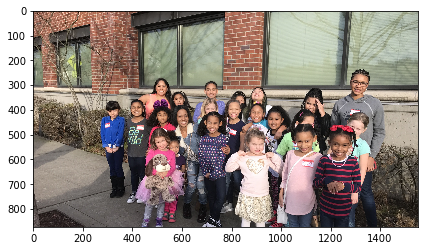

In [45]:
image = imread('0_3990')
imshow(image)

In [35]:
import imquality.brisque as brisque
import PIL.Image

ModuleNotFoundError: No module named 'imquality'

In [41]:
import sys, cpbd

import skimage.io

In [53]:
input_image1 = skimage.io.imread(image)


print("blurry image sharpness:")
cpbd.compute(input_image1)




OSError: Cannot understand given URI: array([[[137,  91,  76],
        [157, 111,  96],
       ....

In [352]:
features.head()

,image,dullness,brightness,average_pixel_width,average_color,average_red,average_green,average_blue,image_size,temp_size,width,height,blurrness
0,94899,0.00,60.88,0.768534,"[240.86637708875867, 212.18375311957465, 138.9...",0.944574,0.832093,0.545000,39944,"(1024, 576)",1024,576,166.027659
1,162481,0.00,0.00,5.192227,"[118.4811774359809, 128.5906219482422, 125.515...",0.464632,0.504277,0.492219,165701,"(1024, 576)",1024,576,791.188786
2,201573,0.00,0.00,5.105082,"[102.67853122287326, 92.08284335666232, 180.79...",0.402661,0.361109,0.708983,140637,"(1024, 576)",1024,576,196.583446
3,159292,0.00,0.00,2.721759,"[75.76579604633861, 110.38401914242864, 143.18...",0.297121,0.432879,0.561527,250948,"(1552, 873)",1552,873,24.676342
4,68557,7.93,0.00,0.367261,"[89.36553211464201, 97.02202309254733, 109.570...",0.350453,0.380479,0.429687,963059,"(1552, 873)",1552,873,2.093685


In [353]:
# Serialize the data table containing the scraped HTML for each project
joblib.dump(features, 'features_full_1.pkl')

['features_full_1.pkl']